# Predicting the Genre of spotify tracks data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans


The data for this project comes from kaggle.
https://www.kaggle.com/datasets/siropo/spotify-multigenre-playlists-data

The data consist of 7 csv files, one file per music genre. 
I'm going to try to use the soings attributes to cluster the songs and see if such clustering fits the genre that comes in the data. 

My approach will be first try some unsupervised methods and see how the data gets clustered which such methods.  The methods will be agglomerative clustering, k means clustering and NMF to get the topics, then I will try some supervised methods to compare the results. 

### Exploratory Data Analysis.
First I load the 7 different files, the name of the genre of the songs is in each file name. 

In [2]:
t1 = pd.read_csv('blues_music_data.csv')
t2 = pd.read_csv('hiphop_music_data.csv')
t3 = pd.read_csv('indie_alt_music_data.csv')
t4 = pd.read_csv('metal_music_data.csv')
t5 = pd.read_csv('pop_music_data.csv')
t6 = pd.read_csv('rock_music_data.csv')
t7 = pd.read_csv('alternative_music_data.csv')

Add the genre column and column id to each dataframe.

In [3]:

t1['Genre'] = 'blues'
t1['Genre_id'] = 0

t2['Genre'] = 'hiphop'
t2['Genre_id'] = 1

t3['Genre'] = 'indie'
t3['Genre_id'] = 2

t4['Genre'] = 'metal'
t4['Genre_id'] = 3

t5["Genre"] = 'pop'
t5['Genre_id'] = 4

t6['Genre'] = 'rock'
t6['Genre_id'] = 5

t7['Genre'] = 'alternative'
t7['Genre_id'] = 6

Join all the data frames in one that be used for the analysis. And take a look at the information of such data frame. How many songs are per genre. I will only use 6 genres.

In [4]:
df = pd.concat([t1,t2, t3, t4, t5, t6], ignore_index=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist Name       24592 non-null  object 
 1   Track Name        24592 non-null  object 
 2   Popularity        24592 non-null  int64  
 3   Genres            24592 non-null  object 
 4   Playlist          24592 non-null  object 
 5   danceability      24592 non-null  float64
 6   energy            24592 non-null  float64
 7   key               24592 non-null  int64  
 8   loudness          24592 non-null  float64
 9   mode              24592 non-null  int64  
 10  speechiness       24592 non-null  float64
 11  acousticness      24592 non-null  float64
 12  instrumentalness  24592 non-null  float64
 13  liveness          24592 non-null  float64
 14  valence           24592 non-null  float64
 15  tempo             24592 non-null  float64
 16  id                24592 non-null  object

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre_id
count,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,24592.000000,2.459200e+04,24592.000000,24592.000000
mean,46.630856,0.552332,0.699467,5.294689,-7.197119,0.619998,0.086761,0.187711,0.105915,0.199162,0.492010,123.591339,2.323517e+05,3.936117,3.230766
std,19.144355,0.167184,0.210599,3.566556,3.260646,0.485397,0.089344,0.265530,0.241141,0.157434,0.233304,29.386652,8.088932e+04,0.333596,1.694650
min,0.000000,0.000000,0.000020,0.000000,-34.825000,0.000000,0.000000,0.000000,0.000000,0.011900,0.000000,0.000000,1.379300e+04,0.000000,0.000000
25%,34.000000,0.439000,0.557000,2.000000,-8.771250,0.000000,0.036000,0.002290,0.000000,0.097400,0.310000,100.002000,1.864050e+05,4.000000,2.000000
50%,46.000000,0.551000,0.730000,5.000000,-6.563000,1.000000,0.051200,0.045900,0.000214,0.134000,0.488000,121.875000,2.180130e+05,4.000000,4.000000
75%,60.000000,0.669000,0.878000,8.000000,-4.936000,1.000000,0.093525,0.287000,0.027825,0.269000,0.671000,143.003500,2.587135e+05,4.000000,5.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.960000,0.996000,0.996000,0.992000,0.986000,249.438000,1.561133e+06,5.000000,5.000000


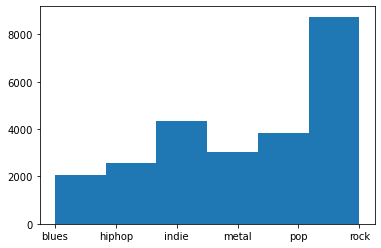

In [6]:
plt.hist(df.Genre,6);

As we can se from the histogram we have four times more rock songs than blues songs. 

The data frame contains 24592 instances, they are all non_null so there will be no need to impute any information. 
To do the models we are going to keep only the instances that are float or int that have information about the song attributes such as danceability, speechiness and so on. 

In [8]:
X = df.iloc[:, 5:16]
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      24592 non-null  float64
 1   energy            24592 non-null  float64
 2   key               24592 non-null  int64  
 3   loudness          24592 non-null  float64
 4   mode              24592 non-null  int64  
 5   speechiness       24592 non-null  float64
 6   acousticness      24592 non-null  float64
 7   instrumentalness  24592 non-null  float64
 8   liveness          24592 non-null  float64
 9   valence           24592 non-null  float64
 10  tempo             24592 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 2.1 MB


We will use 11 features to cluster the songs. All 11 features will be scaled using standard scaling so all the features get the same importance. 

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_t = scaler.transform(X)

## Unsupervised models.
Use different methods to create 6 different clusters

### Agglomerative Clustering.

In [10]:
model = AgglomerativeClustering(n_clusters = 6, linkage= 'complete',
                                affinity = 'euclidean').fit(X_t)
                               


How does our clusters look?

Text(0, 0.5, 'number of songs')

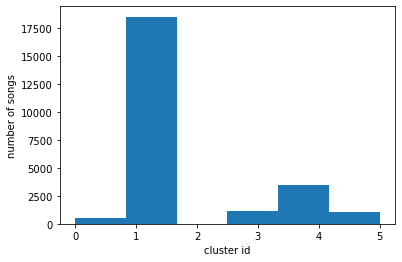

In [11]:
plt.hist(model.labels_,6);
plt.xlabel('cluster id')
plt.ylabel('number of songs')

From the histograms we can see agglomerative clustering is not really clustering the information across genres as the model put most of the songs in the second cluster, while the songs are more evenly spread along the different genres.  If we use the function created in week 2 to check for the accuracy of the algorithm we will see we get quite low accuracy results. 

In [14]:
def label_permute_compare(ytdf,yp,n=6):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    
    # your code here
    #Get all possible permutations of [0,...,n-1] and find the one with the highest accuracy which will signal, the
    #one that corresponds to the actual labels. 
    from itertools import permutations
    perm = permutations(list(range(0, n))) 
    L_names = np.unique(ytdf)
    #Create current best
    current_p = next(perm)
    d_lab = dict(zip(L_names, current_p))
    #Create list of labels with the current permutation tags. 
    new_list = [d_lab[x] for x in ytdf]
    #Calculate accuracy
    acc_curr = accuracy_score(new_list,yp)
    for i in range(1,math.factorial(n)):
        #The challenger permutation
        chall_p = next(perm)
        d_lab = dict(zip(L_names, chall_p))
        new_list = [d_lab[x] for x in ytdf]
        acc_chall = accuracy_score(new_list,yp)
        if acc_chall >= acc_curr:
            current_p = chall_p
            acc_curr = acc_chall
    return current_p, acc_curr

In [15]:
labelorder, acc = label_permute_compare(df.Genre_id, model.labels_)
print(labelorder, acc)

(2, 3, 0, 5, 4, 1) 0.38093689004554326


As expected from the histograms the accuracy is pretty low, looking at the confusion matrix we see that most of the correctly guessed labels correspond to the seconf label, with 7186 correct guesses. But more that that number were predicted to be in that same cluster that correspond to different genres. 

In [16]:
d_lab = dict(zip(np.unique(df.Genre_id), labelorder))
new_list = [d_lab[x] for x in df.Genre_id]
confusion_matrix(new_list,model.labels_)

array([[ 258, 3274,    2,   95,  557,  152],
       [  81, 7186,    1,   82, 1037,  360],
       [  76, 1161,    5,   22,  668,  118],
       [   8, 1528,   17,  762,  120,  146],
       [  29, 2614,    0,  125,  990,   73],
       [  28, 2744,    0,   18,   88,  167]])

Hyperparameter search to see if accuracy can be improved. 

In [18]:
link = ['ward', 'complete', 'average', 'single']
dist = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine',]

#Create data frames to store accuracy of each method.
Acc_mod = pd.DataFrame(columns = link, index = dist)

time_mod = pd.DataFrame(columns = link, index = dist)
Acc_mod.loc[dist[0],link[0]] =1

import time
#loop over linkage methods
for l in link:
    #loop over distances. 
    for d in dist:
        if l == 'ward' and d!='euclidean':
            pass
        else:
            model = AgglomerativeClustering(n_clusters = 5, linkage = l, affinity= d).fit(X_t)
            labelorder, acc = label_permute_compare(df.Genre_id, model.labels_)
            Acc_mod.loc[d,l] = acc 

In [20]:
Acc_mod

,ward,complete,average,single
euclidean,0.361134,0.388785,0.364061,0.355766
l1,NaN,0.395738,0.356539,0.355725
l2,NaN,0.388785,0.364061,0.355766
manhattan,NaN,0.395738,0.356539,0.355725
cosine,NaN,0.348081,0.357881,0.355644


The best results are for the complete linkage with either l1 or manhattan metrics where they approach a 0.4 accuracy. The worst results are for cosine.

### K-means clustering. 

In [21]:
modelk = KMeans(n_clusters=6).fit(X_t)
labelorderk, acck = label_permute_compare(df.Genre_id, modelk.labels_)
print(labelorderk, acck)

(2, 0, 3, 4, 5, 1) 0.33209986987638257


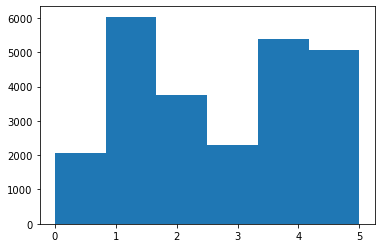

In [22]:
plt.hist(modelk.labels_,6);

In [23]:
d_lab = dict(zip(np.unique(df.Genre_id), labelorderk))
new_list = [d_lab[x] for x in df.Genre_id]
confusion_matrix(new_list,modelk.labels_)

array([[1481,  423,  138,   42,   68,  429],
       [ 118, 2458, 1020,  684, 2651, 1816],
       [  29,  560,  754,  109,  229,  369],
       [ 158, 1175,  805,  751,  663,  786],
       [  22,  274,   88,  656, 1533,  472],
       [ 244, 1146,  957,   59,  235, 1190]])

The results for K-mean clustering are even worst than the ones for agglomerative clustering. 

### NMF 
Factorize the matrix in two matrices to extract 6 topics. Because we need only positive values we adjust the data to be positive. 

In [25]:
X_n = (X_t -X_t.min(axis=0))

In [31]:
from sklearn import decomposition
nmf_mod = decomposition.NMF(n_components=6, max_iter= 500,init = 'nndsvd')

W = nmf_mod.fit_transform(X_n)
H = nmf_mod.components_
print(nmf_mod.reconstruction_err_)
clusters = W.argmax(axis=1)

291.2499447698201


/Users/Aline/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [32]:
labelordern, accn = label_permute_compare(df.Genre_id, clusters)
print(labelordern, accn)

(5, 4, 1, 3, 2, 0) 0.3255530253741054


The results were worst than for previous methods. Try a different initialization as it didnt converge even for a 500 iterations. 


In [33]:
nmf_mod = decomposition.NMF(n_components=6, max_iter= 500,init = 'nndsvda')

W = nmf_mod.fit_transform(X_n)
H = nmf_mod.components_
print(nmf_mod.reconstruction_err_)
clusters = W.argmax(axis=1)

291.107585617446


In [34]:
labelordern, accn = label_permute_compare(df.Genre_id, clusters)
print(labelordern, accn)

(2, 3, 0, 1, 4, 5) 0.36682661027976576


Results are still worse than agglomerative clustering. 

## Supervised Learning models.
Given that the unsupervised models clearly failed to cluster the songs by genre we try using supervised learning. 
First dividing the data set in train and test. 

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_t, df.Genre_id,
                                    test_size=0.3, random_state=32)


In [36]:
### Logistic Regression.

In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=12).fit(x_train, y_train)
print('Accuracy of train' ,accuracy_score(y_train,clf.predict(x_train)))
print('Accuracy of test' ,accuracy_score(y_test,clf.predict(x_test)))


Accuracy of train 0.5260253282212153
Accuracy of test 0.5113851992409867


The results from the logistic regression model are better, but still not good enough as they only predict correclty the genre of a bit more than half of the data. They were also way faster than the unsupervised methods as we didnt need to find the labels correspondance that takes a while. 

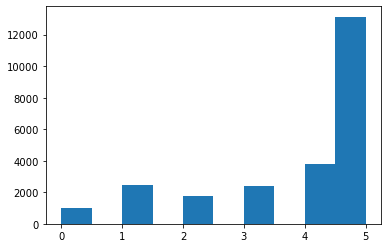

In [45]:
y_pred = clf.predict(np.concatenate((x_test, x_train)))
plt.hist(y_pred);

In [46]:
confusion_matrix(np.concatenate((y_train,y_test)),y_pred)

array([[  83,  209,  134,  192,  315, 1117],
       [ 101,  239,  194,  258,  396, 1393],
       [ 172,  447,  317,  388,  683, 2331],
       [ 133,  302,  207,  324,  441, 1638],
       [ 148,  397,  311,  405,  599, 1971],
       [ 360,  898,  597,  860, 1346, 4686]])

### Random Forest. 


In [50]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=2, random_state=32)
Rfm = RF.fit(x_train, y_train)

print("The train accuracy is: ",np.round(accuracy_score(Rfm.predict(x_train),y_train),3))
print("The test accuracy is: ",np.round(accuracy_score(Rfm.predict(x_test),y_test),3))


The train accuracy is:  0.432
The test accuracy is:  0.425


## Conclusions.
From the models I tried none was great at predicting the genre of the song, the best one was loggistic regresion and got a result a bit above half of the songs were correctly classified. 
This makes me conclude that the songs genres are not based on the features available in the dataset. 
However I thing they could be usefull for a recommendation engine using some similarity matrix. 

